In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/My Drive/DATASET/train.zip' -d /content/dataset/


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/eggplant/Eggplant (17).jpg  
  inflating: /content/dataset/train/eggplant/Eggplant (170).jpg  
  inflating: /content/dataset/train/eggplant/Eggplant (171).jpg  
  inflating: /content/dataset/train/eggplant/Eggplant (172).jpg  
  inflating: /content/dataset/train/eggplant/Eggplant (173).jpg  
  inflating: /content/dataset/train/eggplant/Eggplant (174).jpg  
  inflating: /content/dataset/train/eggplant/Eggplant (175).jpg  
  inflating: /content/dataset/train/eggplant/Eggplant (176).jpg  
  inflating: /content/dataset/train/eggplant/Eggplant (177).jpg  
  inflating: /content/dataset/train/eggplant/Eggplant (178).jpg  
  inflating: /content/dataset/train/eggplant/Eggplant (179).jpg  
  inflating: /content/dataset/train/eggplant/Eggplant (18).jpg  
  inflating: /content/dataset/train/eggplant/Eggplant (180).jpg  
  inflating: /content/dataset/train/eggplant/Eggplant (181).jpg  
  inflating: /content/datas

In [2]:
import os
from PIL import Image
import shutil
import hashlib
from sklearn.model_selection import train_test_split


In [3]:
import os

def check_dataset(directory_path):
    image_files = []
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_files.append(os.path.join(root, file))
    return image_files

dataset_dir = '/content/dataset/train'
image_files = check_dataset(dataset_dir)

print(f"Found {len(image_files)} valid image files in dataset.")


Found 7933 valid image files in dataset.


# CLEANING DATASET #


DUPLICATE REMOVED

In [4]:
def clean_dataset(dataset_dir):
    hashes = set()
    total_removed = 0

    for root, _, files in os.walk(dataset_dir):
        for file in files:
            file_path = os.path.join(root, file)

            if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                print(f"Skipping non-image file: {file_path}")
                continue
            try:
                file_hash = hashlib.md5(open(file_path, 'rb').read()).hexdigest()
                if file_hash in hashes:
                    print(f"Duplicate removed: {file_path}")
                    os.remove(file_path)
                    total_removed += 1
                else:
                    hashes.add(file_hash)
            except Exception as e:
                print(f"Error processing image: {file_path}, Error: {str(e)}")

    print(f"Total duplicates removed: {total_removed}")


SPLIT DATASET

In [5]:
def split_dataset(dataset_dir, output_dir, test_size=0.1, val_size=0.2):
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        images = [os.path.join(class_path, img) for img in images]

        train, test = train_test_split(images, test_size=test_size, random_state=42)
        train, val = train_test_split(train, test_size=val_size, random_state=42)

        for split, split_images in zip(['train', 'val', 'test'], [train, val, test]):
            split_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_images:
                shutil.move(img, os.path.join(split_dir, os.path.basename(img)))

    print("Dataset split completed!")


MENYIMPAN HASIL CLEAN

In [6]:
dataset_dir = '/content/dataset/train'
output_dir = '/content/dataset/cleaned'


clean_dataset(dataset_dir)
split_dataset(dataset_dir, output_dir)


Skipping non-image file: /content/dataset/train/pork/Pork (1).csv
Skipping non-image file: /content/dataset/train/zucchini/Zucchini (1).csv
Skipping non-image file: /content/dataset/train/beef/_annotations.csv
Skipping non-image file: /content/dataset/train/beans/Beans (1).csv
Skipping non-image file: /content/dataset/train/cheese/Cheese (1).csv
Skipping non-image file: /content/dataset/train/butter/Butter (1).csv
Skipping non-image file: /content/dataset/train/egg/Egg (1).csv
Duplicate removed: /content/dataset/train/egg/Egg (183).jpg
Duplicate removed: /content/dataset/train/egg/Egg (14).jpg
Duplicate removed: /content/dataset/train/egg/Egg (414).jpg
Duplicate removed: /content/dataset/train/egg/Egg (335).jpg
Skipping non-image file: /content/dataset/train/rice/Rice (1).csv
Duplicate removed: /content/dataset/train/tomato/Tomato (84).jpeg
Duplicate removed: /content/dataset/train/tomato/Tomato (203).jpeg
Duplicate removed: /content/dataset/train/tomato/Tomato (186).jpeg
Duplicate rem

# TRAINING DATA #

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


DATA AUGMENTATION

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/dataset/cleaned/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/dataset/cleaned/val',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/dataset/cleaned/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 5610 images belonging to 22 classes.
Found 1413 images belonging to 22 classes.
Found 790 images belonging to 22 classes.


TRANSFER LEARNING

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


EarlyStopping untuk menghentikan pelatihan jika validasi berhenti membaik

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)


TRAIN MODEL

In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 63s 288ms/step - accuracy: 0.1650 - loss: 3.1108 - val_accuracy: 0.5782 - val_loss: 1.6770 - learning_rate: 1.0000e-04
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 67s 228ms/step - accuracy: 0.4715 - loss: 1.8540 - val_accuracy: 0.7077 - val_loss: 1.1409 - learning_rate: 1.0000e-04
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 239ms/step - accuracy: 0.5988 - loss: 1.4087 - val_accuracy: 0.7509 - val_loss: 0.8941 - learning_rate: 1.0000e-04
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - accuracy: 0.6403 - loss: 1.2212 - val_accuracy: 0.7919 - val_loss: 0.7508 - learning_rate: 1.0000e-04
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 43s 239ms/step - accuracy: 0.6876 - loss: 1.0701 - val_accuracy: 0.8103 - val_loss: 0.6704 - learning_rate: 1.0000e-04
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 81s 231ms/step - accuracy: 0.7064 - loss: 0.9841 - val_accuracy: 0.8231 - val_loss: 0.6127 - learning_rate: 1.0000e-04
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 81s 228ms/step - 

EVALUASI

In [13]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.8731 - loss: 0.3874
Test Accuracy: 87.47%
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.8744 - loss: 0.3820
Validation Accuracy: 87.12%


# VISUALISASI DATA #

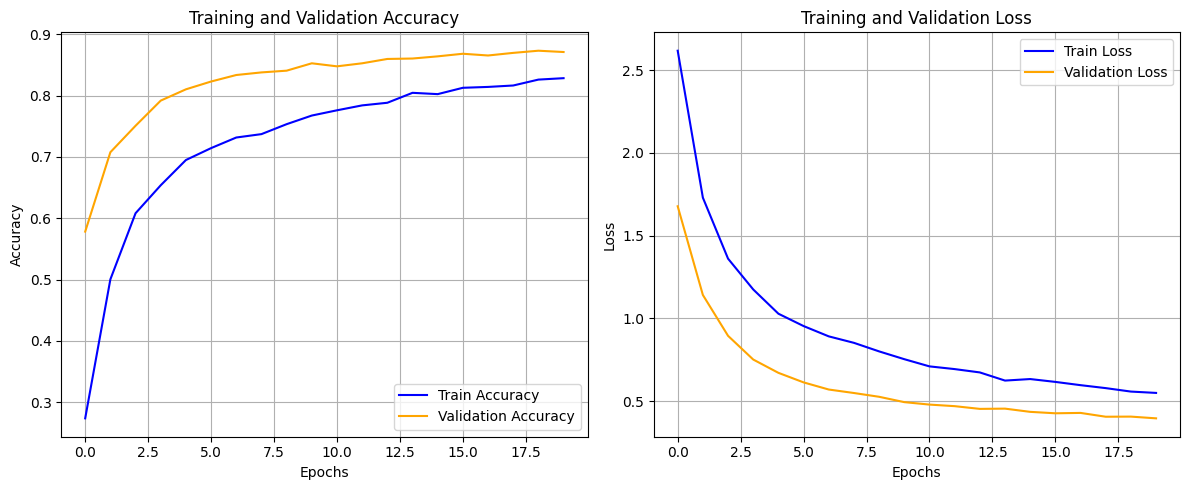

In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


# CEK CLASS & IMAGE #

In [22]:
test_dir = '/content/dataset/cleaned/test'

def list_all_images(dataset_dir):
    print(f"Listing all images in {dataset_dir}:")
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            print(f"\nClass '{class_name}':")
            for img in images:
                print(f"  {img}")

list_all_images(test_dir)


Listing all images in /content/dataset/cleaned/test:

Class 'pork':
  Pork (138).jpg
  Pork (147).jpg
  Pork (155).jpg
  Pork (240).jpg
  Pork (120).jpg
  Pork (65).jpg
  Pork (254).jpg
  Pork (6).jpg
  Pork (183).jpg
  Pork (82).jpg
  Pork (225).jpg
  Pork (28).jpg
  Pork (142).jpg
  Pork (146).jpg
  Pork (136).jpg
  Pork (157).jpg
  Pork (212).jpg
  Pork (199).jpg
  Pork (134).jpg
  Pork (156).jpg
  Pork (91).jpg
  Pork (160).jpg
  Pork (239).jpg
  Pork (113).jpg
  Pork (43).jpg
  Pork (81).jpg

Class 'zucchini':
  Zucchini (106).jpg
  Zucchini (147).jpg
  Zucchini (461).jpg
  Zucchini (392).jpg
  Zucchini (196).jpg
  Zucchini (113).jpg
  Zucchini (822).jpg
  Zucchini (880).jpg
  Zucchini (813).jpg
  Zucchini (902).jpg
  Zucchini (42).jpg
  Zucchini (1).csv
  Zucchini (36).jpg
  Zucchini (605).jpg
  Zucchini (810).jpg
  Zucchini (542).jpg
  Zucchini (649).jpg
  Zucchini (678).jpg
  Zucchini (134).jpg
  Zucchini (270).jpg
  Zucchini (611).jpg
  Zucchini (82).jpg
  Zucchini (190).jpg
 

## PREDIKSI IMAGE ##

PREDIKSI MENGGUNAKAN DATA TEST

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Class: eggplant with Confidence: 83.89%


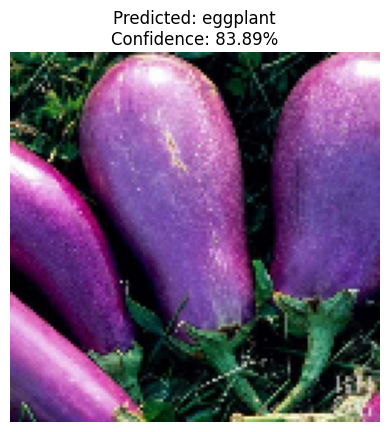

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

sample_image_path = '/content/dataset/cleaned/test/eggplant/Eggplant (314).jpg'

img = load_img(sample_image_path, target_size=(128, 128))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class] * 100

class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(f"Predicted Class: {predicted_label} with Confidence: {confidence:.2f}%")

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}%")
plt.show()


PREDIKSI 1 IMAGE

Saving WhatsApp Image 2024-12-03 at 12.45.34_e4019aef.jpg to WhatsApp Image 2024-12-03 at 12.45.34_e4019aef.jpg
Uploaded image: WhatsApp Image 2024-12-03 at 12.45.34_e4019aef.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Class: egg with Confidence: 98.62%
This is a valid class: egg.


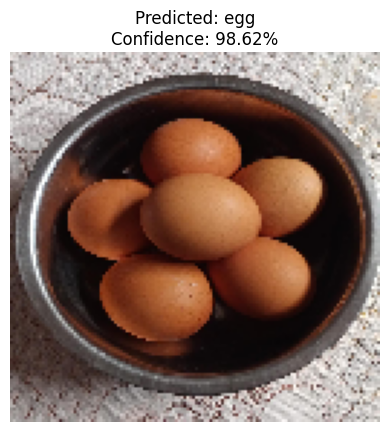

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files

def upload_and_predict_image(model, train_generator):
    uploaded = files.upload()
    image_path = next(iter(uploaded))
    print(f"Uploaded image: {image_path}")

    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class] * 100
    class_labels = list(train_generator.class_indices.keys())
    predicted_label = class_labels[predicted_class]

    print(f"Predicted Class: {predicted_label} with Confidence: {confidence:.2f}%")

    if predicted_label in class_labels:
        print(f"This is a valid class: {predicted_label}.")
    else:
        print("This class is not found in the dataset.")

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}%")
    plt.show()

upload_and_predict_image(model, train_generator)


PREDIKSI BANYAK IMAGE

Saving test3.jpeg to test3.jpeg
Saving test2.jpg to test2.jpg
Saving test.jpg to test.jpg
Uploaded image: test3.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Class: carrot with Confidence: 96.56%
Uploaded image: test2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Class: egg with Confidence: 98.62%
Uploaded image: test.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Class: tomato with Confidence: 87.91%


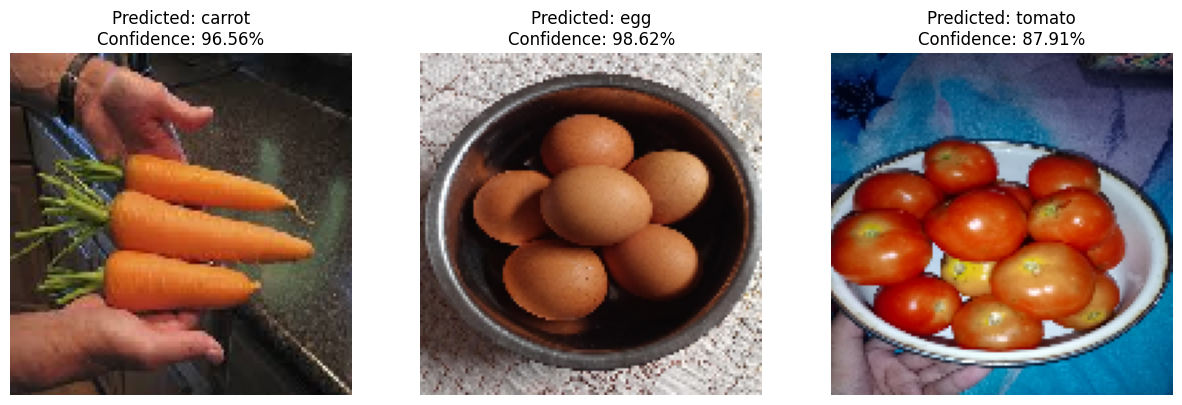

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files

def upload_and_predict_multiple_images(model, train_generator):
    uploaded = files.upload()
    num_images = len(uploaded)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    if num_images == 1:
        axes = [axes]

    for idx, image_path in enumerate(uploaded.keys()):
        print(f"Uploaded image: {image_path}")

        img = load_img(image_path, target_size=(128, 128))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class] * 100
        class_labels = list(train_generator.class_indices.keys())
        predicted_label = class_labels[predicted_class]

        print(f"Predicted Class: {predicted_label} with Confidence: {confidence:.2f}%")

        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}%")

    plt.show()

upload_and_predict_multiple_images(model, train_generator)


# SAVE MODEL #

In [31]:
model.save('/content/model.keras')
model.save('/content/model.h5')


In [32]:
model_json = model.to_json()
with open("/content/model.json", "w") as json_file:
    json_file.write(model_json)


In [38]:
model.save_weights('/content/model_weights.weights.h5')


In [39]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("/content/model.tflite", "wb") as tflite_file:
    tflite_file.write(tflite_model)


Saved artifact at '/tmp/tmprbtefnxq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 22), dtype=tf.float32, name=None)
Captures:
  137938985567680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137937583768672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137937583773248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137937583772016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137937583772192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137937583770608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137937471474848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137937471475376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137937471475552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137937471475024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137937583

In [42]:
from google.colab import files

# Download .keras file
files.download('/content/model.keras')

# Download .json file
files.download('/content/model.json')

# Download .tflite file
files.download('/content/model.tflite')

# Download weights if saved separately
files.download('/content/model_weights.weights.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>